In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# cantidad de ejemplos por batch
batch_size = 32
# porcentaje para validar y para el test
test_size = 0.3
valid_size = 0.1

# convertir y normalizar data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [3]:
data = datasets.ImageFolder('face2',transform=transform)


#Data para test
num_data = len(data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
np.random.shuffle(indices_data)
split_tt = int(np.floor(test_size * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]


#Data para Validar
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]


# Subset de pytorch
train_sampler = SubsetRandomSampler(train_new_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

print(len(train_sampler))
print(len(test_sampler))
print(len(valid_sampler))


189
90
21


In [4]:
data

Dataset ImageFolder
    Number of datapoints: 300
    Root location: face2

In [5]:
# agrupar los subsets en batch
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
    sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(data, sampler = test_sampler, batch_size=batch_size, 
    num_workers=1)
# Definiendo clases - Al leer el directorio lo ordena alfabeticamente

nombres = ["andre","elias","nash"]
classes = range(len(nombres))#[0,1,2]
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

6
1
3


In [6]:
len(test_loader)*batch_size + len(valid_loader)*batch_size + len(train_loader)*batch_size

320

In [7]:
for batch in valid_loader:
    print(batch[0].size())

torch.Size([21, 3, 224, 224])


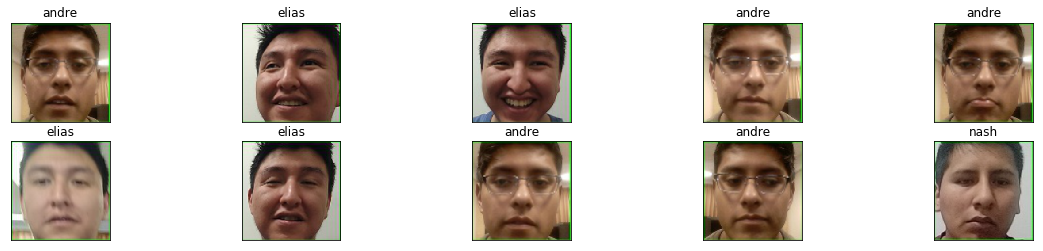

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Desnormalizar la imagen y verla
def imshow(img):
    img = img / 2 + 0.5 
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convertir Tensor a Imagen
    
# Obtener el batch para monstrar
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 


fig = plt.figure(figsize=(20, 4))
# Ver imagenes
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(nombres[classes[labels[idx]] ])

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# Heredar aquitectura de nn de torch
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # conv layer
        self.conv1 = nn.Conv2d(3, 16, 5)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # conv2 layer
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*53*53, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, len(classes)) #Ultima capa
        self.softmax = nn.LogSoftmax(dim=1)

        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

# create a complete CNN
model = Net()
print(model)


Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.2)
  (fc1): Linear(in_features=89888, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
  (softmax): LogSoftmax()
)


In [10]:
import torch.optim as optim

# specify loss function
criterion = torch.nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum= 0.9)

In [11]:
# Numero de epocas o iteraciones para entrenar
n_epochs = 15

valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train() # modo entrenamiento
    cont=0
    for data, target in train_loader:
        cont+=1

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    model.eval() # modo evaluacion para validar
    cont=0

    for data, target in valid_loader:
        cont+=1
        
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    print('Iteracion : {} \tPerdida entrenamiento: {:.6f} \tPerdida Validacion: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    # Guardar el modelo
    if valid_loss <= valid_loss_min:
        print('La perdida en Validacion se redujo: ({:.6f} --> {:.6f}).'.format(valid_loss_min,valid_loss))
        #torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Iteracion : 1 	Perdida entrenamiento: 0.691131 	Perdida Validacion: 0.074305
La perdida en Validacion se redujo: (inf --> 0.074305).
Iteracion : 2 	Perdida entrenamiento: 0.646996 	Perdida Validacion: 0.066643
La perdida en Validacion se redujo: (0.074305 --> 0.066643).
Iteracion : 3 	Perdida entrenamiento: 0.559479 	Perdida Validacion: 0.055038
La perdida en Validacion se redujo: (0.066643 --> 0.055038).
Iteracion : 4 	Perdida entrenamiento: 0.507459 	Perdida Validacion: 0.052832
La perdida en Validacion se redujo: (0.055038 --> 0.052832).
Iteracion : 5 	Perdida entrenamiento: 0.442403 	Perdida Validacion: 0.044644
La perdida en Validacion se redujo: (0.052832 --> 0.044644).
Iteracion : 6 	Perdida entrenamiento: 0.352144 	Perdida Validacion: 0.026811
La perdida en Validacion se redujo: (0.044644 --> 0.026811).
Iteracion : 7 	Perdida entrenamiento: 0.207835 	Perdida Validacion: 0.012822
La perdida en Validacion se redujo: (0.026811 --> 0.012822).
Iteracion : 8 	Perdida entrenamiento: 0

In [12]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range( len(classes) ))
class_total = list(0. for i in range( len(classes) ))

model.eval()
i=1
# iterate over test data
for data, target in test_loader:
    i=i+1
    if len(target)!=batch_size:
        continue
        
    output = model(data)
    loss = criterion(output, target)

    test_loss += loss.item()*data.size(0)

    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) #if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    for i in range(batch_size):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            nombres[classes[i]], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (nombres[classes[i]]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % 
      (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.027807

Test Accuracy of andre: 100% (16/16)
Test Accuracy of elias: 100% (26/26)
Test Accuracy of  nash: 90% (20/22)

Test Accuracy (Overall): 96% (62/64)


In [13]:
from PIL import Image
def process_image(image_path):
    img = Image.open(image_path)
    width, height = img.size
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    width, height = img.size
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    img = np.array(img)
    
    img = img.transpose((2, 0, 1))
    
    img = img/255
    
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    img = img[np.newaxis,:]
    
    image = torch.from_numpy(img)
    image = image.float()
    return image


def predict(image, model):
    output = model.forward(image)

    output = torch.exp(output)
    
    # probablildad de clase
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()


def show_image(image):
    image = image.numpy()
    image[0] = image[0] * 0.226 + 0.445
    
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Es un  99.11078810691833 % probable que sea  elias


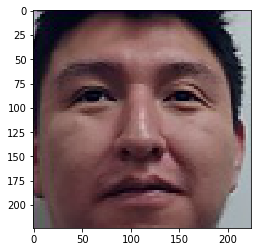

In [19]:
image = process_image("prueba/elias.jpg")

top_prob, top_class = predict(image, model)

show_image(image)

print("Es un ", top_prob*100, "% probable que sea ", nombres[top_class]  )